In [38]:
import pandas as pd
import numpy as np

import datetime
from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
users_df = pd.read_csv('takehome_users.csv', encoding='latin-1')
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [3]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [4]:
engage_df = pd.read_csv('takehome_user_engagement.csv')
engage_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
engage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


First we need to label the users as adopted user if they have logged into the product on three separate days in at least one sevenday period. For that `time_stamp` should have appropriate data type.

In [6]:
engage_df['time_stamp'] = pd.to_datetime(engage_df['time_stamp'])
engage_df.dtypes

time_stamp    datetime64[ns]
user_id                int64
visited                int64
dtype: object

In [7]:
engage_df.set_index('time_stamp', drop=True, inplace=True)
engage_df.head()

,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1


In [8]:

def label_user(x):
    # filter for current user_id rows in engage_df
    temp_df = engage_df.loc[engage_df.user_id == x]
    # use resampling on time series based on day
    temp_df = temp_df.resample('D').mean().dropna() 
    
    adopted_flag = 0
    for i in range(len(temp_df)-2): 
        if temp_df.index[i + 2] - temp_df.index[i] <= timedelta(days=7): # difference between every 1st and 3rd day
                adopted_flag = 1
                break 
    return adopted_flag
    

In [9]:
users_df['adopted_user'] = users_df['object_id'].apply(label_user)
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [10]:
users_df.adopted_user.sum()

1656

In [11]:
# Percentage of adopted users
(users_df.adopted_user.sum() / len(users_df)) * 100

13.8

Now we know that 13.8% of users are adopted users. Before doing further analysis, we need to do some data wrangling.

### Data Wrangling

In [12]:
# Update data types
users_df['creation_time'] = pd.to_datetime(users_df.creation_time)
#last_session_creation_time is a unix time stamp, so use map to convert to datetime
users_df['last_session_creation_time'] = users_df['last_session_creation_time'].map(lambda data: 
                                    datetime.datetime.fromtimestamp(int(data)).strftime('%Y-%m-%d %H:%M:%S'),
                                                                              na_action='ignore')

In [13]:
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'])
#subtract to find time active
users_df['usage_length'] = users_df['last_session_creation_time'] - users_df['creation_time']
users_df['usage_length'] = [x.total_seconds() for x in users_df['usage_length']]

In [14]:
users_df.loc[users_df['usage_length'] <0, 'usage_length'] = 0
users_df['usage_length'].fillna(0, inplace=True)
users_df['invited_by_user_id'].fillna(0, inplace=True)

In [17]:
users_df['email_provider'] = [x.split('@')[1] for x in users_df.email]#select out the domain
top_emails = users_df.email_provider.value_counts().index[:6]
#label anything not in the top 5 as other
users_df['email_provider'] = [x if x in top_emails else 'other' for x in users_df.email_provider]

In [15]:
drop_cols = ['object_id', 'creation_time', 'name', 'last_session_creation_time', 'email']
users_df.drop(columns=drop_cols, inplace=True)

In [19]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_source             12000 non-null  object 
 1   opted_in_to_mailing_list    12000 non-null  int64  
 2   enabled_for_marketing_drip  12000 non-null  int64  
 3   org_id                      12000 non-null  int64  
 4   invited_by_user_id          12000 non-null  float64
 5   adopted_user                12000 non-null  int64  
 6   usage_length                12000 non-null  float64
 7   email_provider              12000 non-null  object 
dtypes: float64(2), int64(4), object(2)
memory usage: 750.1+ KB


In [20]:
from sklearn.preprocessing import LabelEncoder

gle = LabelEncoder()
creation_labels = gle.fit_transform(users_df['creation_source'])
users_df.creation_source = creation_labels

org_id_labels = gle.fit_transform(users_df['org_id'])
users_df.org_id = org_id_labels

invited_labels = gle.fit_transform(users_df['invited_by_user_id'])
users_df.org_id = invited_labels

email_labels = gle.fit_transform(users_df['email_provider'])
users_df.email_provider = email_labels

users_df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,usage_length,email_provider
0,0,1,0,2325,10803.0,0,0.0,6
1,1,0,0,56,316.0,1,11725200.0,2
2,1,0,0,298,1525.0,0,0.0,2
3,0,0,0,1104,5151.0,0,61200.0,6
4,0,0,0,1127,5240.0,0,403200.0,6


In [29]:
X = users_df.drop(columns='adopted_user')
y = users_df['adopted_user']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [30]:


#train and test classifier
rf = RandomForestClassifier(class_weight='balanced_subsample')

rf.fit(X_train, y_train)

rf.score(X_test, y_test)

0.9722222222222222

In [32]:
feature_importance = pd.DataFrame()
feature_importance['coef'] = rf.feature_importances_
feature_importance = feature_importance.set_index(X.columns)
feature_importance.coef.nlargest(10)

usage_length                  0.922447
org_id                        0.022385
invited_by_user_id            0.021834
email_provider                0.016085
creation_source               0.010222
opted_in_to_mailing_list      0.003713
enabled_for_marketing_drip    0.003314
Name: coef, dtype: float64

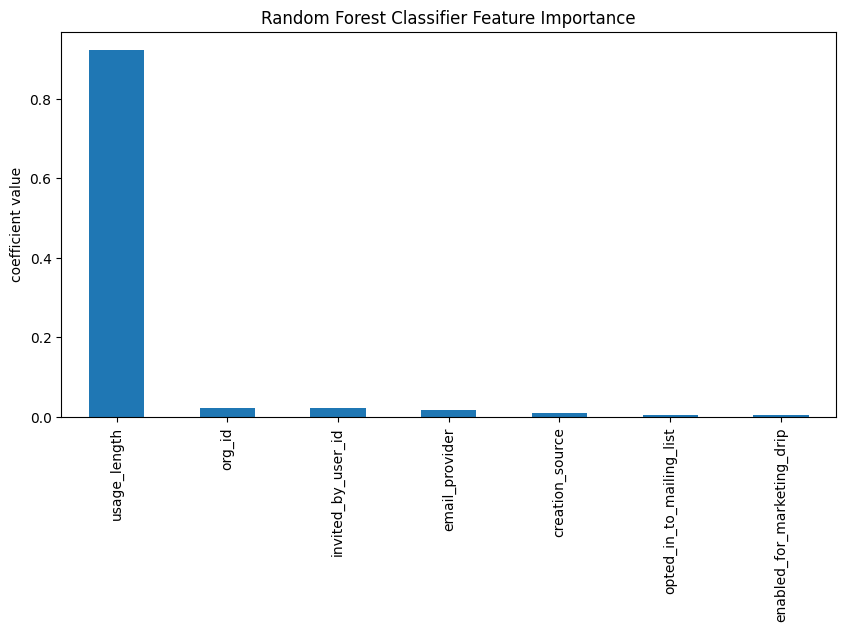

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
(feature_importance['coef']).nlargest(10).plot(kind='bar', x=feature_importance.index)
plt.title('Random Forest Classifier Feature Importance')
plt.ylabel('coefficient value')
plt.show()

In [34]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

In [36]:
adopted = users_df.usage_length.loc[users_df['adopted_user'] == 1]
not_adopted = users_df.usage_length.loc[users_df['adopted_user'] == 0]

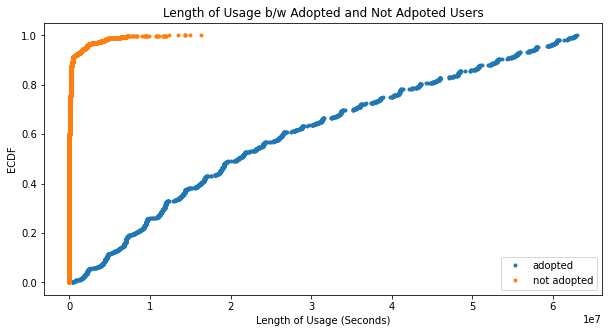

In [39]:
#set fig size
%matplotlib inline
plt.figure(figsize=(10,5))

x_active, y_active = ecdf(adopted)
x_inactive, y_inactive = ecdf(not_adopted)

plt.plot(x_active, y_active, marker='.', linestyle='none')
plt.plot(x_inactive, y_inactive, marker='.', linestyle='none')
plt.title('Length of Usage b/w Adopted and Not Adpoted Users')
plt.xlabel('Length of Usage (Seconds)')
plt.ylabel('ECDF')
plt.legend(['adopted', 'not adopted'])
plt.show()

### Findings:
* In the current dataset, around 14% users are adoptive users.
* The length of sessions (usage_length) is an important feature that helps to predict adoptive users
 